# Overfitting

... Normally? A bad thing! But for our case it's good...

We use a new method to mix an overfitted model (our own) with a pretrained model (GPT-Neo-125M) and have them share eachothers traits. This way it's possible to finetune a model without having to retrain it. It's so fast it can be done in a second on CPU.

In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import content_aware_encode, train_model, split_data, split_branches, get_model, set_pretrained_model_dropout, get_dataset, ModelSeeder
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import time
import onnx
import logging
from onnx_model_manager import OnnxModelManager
from onnxruntime.quantization import quantize_dynamic, QuantType
import os
import datasets
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager

In [2]:
# seed = random.randint(0, 2 ** 32 - 1)
seed = 970988852
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 970988852


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    'lr': 1e-5,
    "warmup_factor": 1,
    'scheduler': 'cosine_schedule_with_warmup',
    "lr_end": 2e-6,
    "power": 0.6,
    "freeze_from_steps": -1,
    # 'freeze_layer_rate': 2e-5,
    'to_freeze_count': 0,
    "seed": seed,
    "num_epoch": 70
}

In [5]:
saved_model_path = os.path.join("models", "awsw_main")
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
    model = AutoModelForCausalLM.from_pretrained(saved_model_path)
    print("Pretrained model loaded")
else:
    model, tokenizer = get_model("EleutherAI/gpt-neo-125M")
    print("Loaded empty model")
model = model.to(device)
set_pretrained_model_dropout(model.transformer.h, 0.005)

Loaded empty model


# Test before training on a pretrained model!

In [6]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer, device=device)
def test_regular_sampler():
    print(model_manager.say_raw("In my dreams, I'm a dragon", 50, 0.7))
test_regular_sampler()

In my dreams, I'm a dragon.

I can tell you I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a dragon. I'm a


# Reviewing our dataset!

In [7]:
dataset = get_dataset(tokenizer, path_train = os.path.join(Config.work_dir, "data_train.txt"))
with open("data_train_sample.txt", 'w') as f:
    for i, item in enumerate(dataset['train']):
        f.write(tokenizer.decode(item['input_ids']) + "\n")
        
print("RP review!")
to_see_rp = [
    'c "Fight ',
    'c "What do you think of Lorem?'
]
for item in dataset['train']:
    decoded = tokenizer.decode(item['input_ids'])
    for rp in list(to_see_rp):
        if rp in decoded: 
            print(decoded)
            print("-" * 10)
            to_see_rp.remove(rp)
            continue
    if len(to_see_rp) == 0:
        break
# Clean up
del to_see_rp

  0%|          | 0/2 [00:00<?, ?it/s]

RP review!
><msg>c "Hello Remy"<d><scn>loremapt<msg>Ry "Hey [player_name]! How are you?"<p><msg>c "I don't think I've heard that one before."<d><scn>loremapt<msg>Lo "The short version is that some believe we were created by a human. What happened to that human after we were made is a mystery, though. Some think they turned into a dragon and lived among us."<p><msg>c "What do you think of Lorem?"<d
----------


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [8]:
train_results = {}
model.train()
train_model(model, tokenizer, dataset, config, train_results)

[0] set freeze_part_layers: True (freezing 0 out of 160 layers.)


Step,Training Loss
52,6.559000
104,6.263300
156,5.929400
208,5.601600
260,5.298900
312,5.016200
364,4.768900
416,4.559200
468,4.461100
520,4.299600


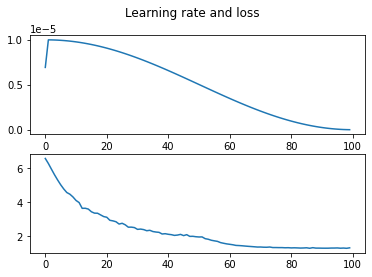

In [9]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

In [10]:
model.eval()
model.save_pretrained(saved_model_path)

In [11]:
test_rps = [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight",
    "Bite",
    "Attack"
]

for rp in test_rps:
    print(f'{rp} -> {model_manager.say("", rp)}')
    print(f'[sampled] {rp} -> {model_manager.say("", rp, top_k = 50, top_p = 0.7)}')
    print("-" * 10)
    
print("Lowercase test")

for rp in test_rps:
    rp = rp[0].lower() + rp[1:]
    print(f'{rp} -> {model_manager.say("", rp)}')
    rp = rp.lower()
    print(f'{rp} -> {model_manager.say("", rp)}')
    print("-" * 10)

Visit Lorem -> loremapt<msg>Lo "Hey [player_name]!"<p><msg>c "What do you think of Sebastian?"<d><scn>loremapt<msg>Lo "I think he is ugly."<p><msg>c "What do you think of Adine?"<d><scn>loremapt<msg>Lo "I think she is ugly."<p><msg>c "What do you think of Adine?"<d><sc
[sampled] Visit Lorem -> loremapt<msg>Lo "Hey [player_name]!"<p><msg>c "Go to Maverick"<d><scn>park3<msg>Mv "Oh, [player_name], I didn't expect you to arrive so early."<d><scn>loremapt<msg>Lo "What are you talking about?"<p><msg>c "That would be a huge amount of work."<p><msg>c "Go to Remy
----------
Meet with Lorem -> loremapt<msg>Lo "Hey [player_name]!"<d><scn>loremapt<msg>Lo "Oh, [player_name], I wasn't expecting visitors."<p><msg>c "What do you think of Katsuharu?"<d><scn>loremapt<msg>Lo "I think he is good looking."<p><msg>c "What do you think of Adine?"<d><scn>loremapt
[sampled] Meet with Lorem -> loremapt<msg>Lo "Oh, [player_name], I didn't expect you to arrive so early."<p><msg>c "go to reza"<d><scn>park2<msg>Rz 

In [12]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hello, [player_name]."', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

def prompt_test(model_manager, do_sample_test = True):
    for (past, prompt) in prompts:
        print(f"Prompt: {prompt}")
        reply = model_manager.say(past, prompt)
        print(f"Reply: {reply}")
        if do_sample_test:
            reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
            print(f"Reply [sampled]: {reply}")
        print("-" * 10)
        
prompt_test(model_manager)

Prompt: How are you?
Reply: park2<msg>Ry "I'm not sure if I should be here anymore."<p><msg>c "What do you think of Sebastian?"<d><scn>park2<msg>Sb "I think he's good looking."<p><msg>c "What do you think of Lorem?"<d><scn
Reply [sampled]: pad<msg>Rz "I'm not sure. How can I help you?"<p><msg>c "I'm here for your kind of work."<p><msg>c "I was a reporter for a magazine in the summer."<d><scn>pad<msg>Ry "Oh, I wasn't expecting visitors."<p
----------
Prompt: What do you think of Lorem?
Reply: park2<msg>Ad "I think he is good looking."<p><msg>c "I think he is good looking."<d><scn>park2<msg>Ad "I think he is good looking."<p><msg>c "I was with Lorem today."<d><scn>park
Reply [sampled]: park2<msg>Ad "I think he is ugly."<p><msg>c "What do you think of Katsuharu?"<d><scn>park2<msg>Ad "I think he is ugly."<p><msg>c "Go to Katsuharu"<d><scn>park2
----------
Prompt: Oh my god, Adine. What is this?
Reply: o<msg>Ad "I'm not sure. I'm not sure if I should go."<p><msg>c "What do you think of Kats